1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [30]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!date

Thu Feb  8 01:59:44 EST 2018


In [3]:
project_name='plant-seedlings-classification'

In [4]:
import os, sys

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.conv_learner import *
import os

In [7]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

In [8]:
! pwd

/home/paperspace/fastai/courses/dl1


## Get data

### Directory based structure

In [23]:
!ls {PATH}

lr_plot.png  sample_submission.csv.zip	tmp    train.zip
models	     test			train  valid


In [24]:
notebook_dir = os.getcwd()
notebook_dir

'/home/paperspace/fastai/courses/dl1'

In [25]:
os.chdir(PATH)

In [26]:
! pwd

/home/paperspace/data/seeds


In [ ]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [27]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [28]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['c9b1820d0.png',
 '5c7abc049.png',
 '9d588ace5.png',
 '3ad5d809c.png',
 'b496ed692.png',
 '084d21b80.png',
 'a5c2eec2d.png',
 '85ae913c3.png',
 '66e90b455.png',
 '266211c3c.png']

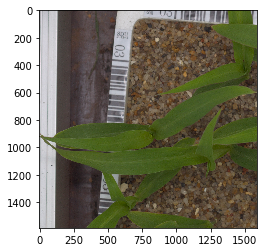

In [31]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [32]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1588, 1588, 3)

In [33]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['16e38d4af.png',
 '69f06fcbc.png',
 '7446f241c.png',
 '50c80a5e4.png',
 '8bfe6860d.png',
 '18b6755a1.png',
 '55083690a.png',
 '3ef465952.png',
 '606d5c83f.png',
 'ff4b55219.png']

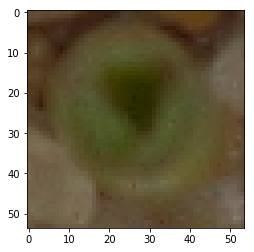

In [34]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [35]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(54, 54, 3)

In [36]:
os.chdir(notebook_dir)

In [37]:
! pwd

/home/paperspace/fastai/courses/dl1


In [38]:
arch=resnet34
size=100
bs=64 # default
#metrics=[f2]

In [39]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [40]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_top_down)

In [41]:
def get_aug_tfms(f_model, size, zoom): return tfms_from_model(f_model, size, aug_tfms=transforms_top_down, max_zoom=zoom)

In [42]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg', bs=bs)

In [43]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test', bs=bs)

# Enable data augmentation, and precompute=True

## Initial model setup

In [44]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.3))
data = data.resize(int(size*1.5), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [45]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [46]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 48%|████▊     | 32/67 [00:00<00:00, 37.40it/s, loss=10.6]


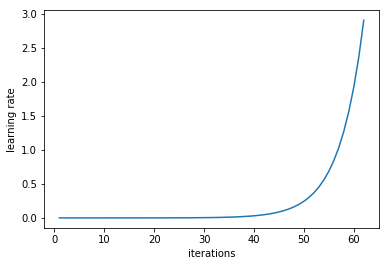

In [47]:
learn.sched.plot_lr()

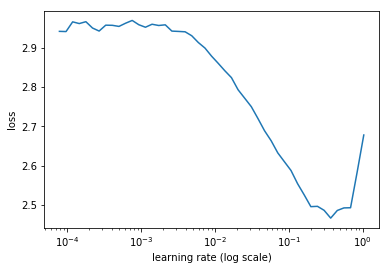

In [48]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [49]:
#learning_rate = 0.15 - best results thus far with 60/150/300
learning_rate = 0.1
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.870742   1.336388   0.564598  
    1      1.642086   1.206849   0.617549                 
    2      1.216783   0.934417   0.683883                 
    3      1.170221   1.02618    0.662688                 
    4      1.04203    0.953116   0.677083                 
    5      0.885926   0.8459     0.720269                  
    6      0.796886   0.877925   0.713686                  

CPU times: user 4.73 s, sys: 4.5 s, total: 9.22 s
Wall time: 6.57 s


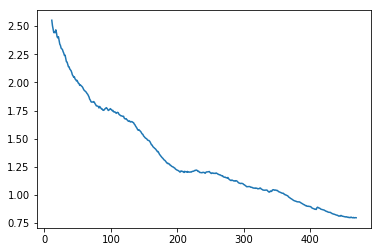

In [50]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.907521   0.49844    0.831597  
    1      0.607362   0.496688   0.825738                  
    2      0.358437   0.219151   0.93287                   
    3      0.384349   0.788188   0.768591                  
    4      0.257477   0.332109   0.893374                  
    5      0.146561   0.188582   0.944589                  
    6      0.085024   0.171237   0.952402                   

CPU times: user 2min 19s, sys: 42.4 s, total: 3min 2s
Wall time: 2min 18s


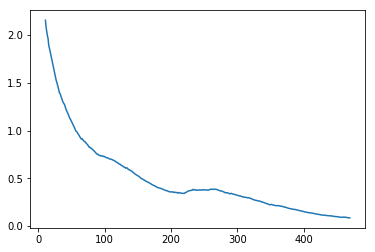

In [51]:
learn.precompute=False

learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [52]:
size = 150
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.1))
data = data.resize(int(size*1.1), 'tmp')
learn.set_data(data)


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.259042   0.213652   0.934823  
    1      0.23268    0.187783   0.93873                   
    2      0.208493   0.187026   0.940683                  
    3      0.215902   0.192446   0.936777                  
    4      0.201141   0.176186   0.934823                  
    5      0.185057   0.174849   0.940683                  
    6      0.177055   0.174458   0.93873                   

CPU times: user 1min 52s, sys: 23.3 s, total: 2min 15s
Wall time: 1min 15s


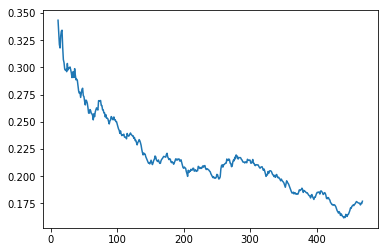

In [53]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.311972   0.190056   0.942636  
    1      0.290586   0.2586     0.921152                  
    2      0.165618   0.137489   0.956308                  
    3      0.170098   0.489433   0.83478                   
    4      0.129448   0.202389   0.950448                  
    5      0.068311   0.120533   0.960214                   
    6      0.035444   0.122714   0.960214                   

CPU times: user 3min 43s, sys: 1min 10s, total: 4min 54s
Wall time: 3min 54s


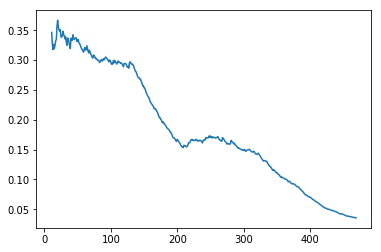

In [54]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [55]:
size = 300
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.382455   0.292677   0.909433  
    1      0.307216   0.245488   0.913845                  
    2      0.254417   0.222512   0.931641                  
    3      0.249058   0.205435   0.939453                  
    4      0.230798   0.196517   0.932147                  
    5      0.20261    0.18398    0.944589                  
    6      0.173608   0.183091   0.936053                  

CPU times: user 9min 42s, sys: 1min 53s, total: 11min 35s
Wall time: 5min 2s


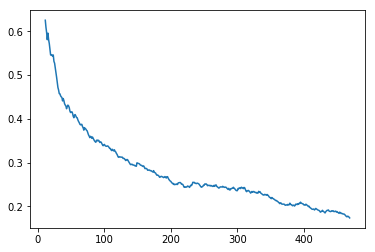

In [56]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.365485   0.134954   0.964844  
    1      0.260073   0.172844   0.942636                  
    2      0.133351   0.09244    0.976562                  
    3      0.133343   0.152853   0.960214                  
    4      0.097886   0.143354   0.96412                    
    5      0.051812   0.115191   0.975839                   
    6      0.031282   0.099958   0.979745                   

CPU times: user 16min 5s, sys: 4min 16s, total: 20min 22s
Wall time: 13min 49s


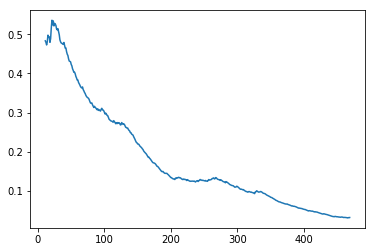

In [57]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [64]:
size = 500
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05))
data = data.resize(int(size*0.6), 'tmp')
learn.set_data(data)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [65]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)
# %time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=3)


learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.132976   0.13939    0.952402  
    1      0.106778   0.128262   0.956308                  
    2      0.093667   0.123304   0.960214                   
    3      0.090698   0.128815   0.958261                   
    4      0.091014   0.12009    0.958261                   
    5      0.079372   0.118116   0.968027                   
    6      0.077015   0.117257   0.962167                   

CPU times: user 19min 26s, sys: 6min 30s, total: 25min 57s
Wall time: 16min 53s


In [ ]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [ ]:
size = 600

data = get_data_from_dir(arch, size, get_aug_tfms(arch, size, zoom=1.05))
data = data.resize(int(size*0.6), 'tmp')
learn.set_data(data)

In [ ]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

In [ ]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [58]:
log_preds, y = learn.TTA()

In [59]:
log_preds.shape

(5, 475, 12)

In [60]:
log_preds[:,0,:]

array([[ -0.55486, -14.36646, -11.53625, -11.72041,  -7.58358, -10.55393,  -0.85521, -11.2114 , -11.45724,
        -11.69717,  -9.64492, -13.55271],
       [ -0.55486, -14.36646, -11.53625, -11.72041,  -7.58358, -10.55393,  -0.85521, -11.2114 , -11.45724,
        -11.69717,  -9.64492, -13.55271],
       [ -0.55486, -14.36646, -11.53625, -11.72041,  -7.58358, -10.55393,  -0.85521, -11.2114 , -11.45724,
        -11.69717,  -9.64492, -13.55271],
       [ -0.55486, -14.36646, -11.53625, -11.72041,  -7.58358, -10.55393,  -0.85521, -11.2114 , -11.45724,
        -11.69717,  -9.64492, -13.55271],
       [ -0.55486, -14.36646, -11.53625, -11.72041,  -7.58358, -10.55393,  -0.85521, -11.2114 , -11.45724,
        -11.69717,  -9.64492, -13.55271]], dtype=float32)

In [61]:
y.shape

(475,)

In [62]:
y[15:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [63]:
y.max()

11

In [64]:
probs = np.mean(np.exp(log_preds), 0)

In [65]:
probs.shape

(475, 12)

In [66]:
probs[0,:]

array([0.57415, 0.     , 0.00001, 0.00001, 0.00051, 0.00003, 0.4252 , 0.00001, 0.00001, 0.00001, 0.00006,
       0.     ], dtype=float32)

In [67]:
accuracy_np(probs, y)

0.9810526315789474

In [68]:
from sklearn.metrics import f1_score

In [69]:
probs_idx = np.argmax(probs, axis=1)
probs_idx.shape

(475,)

In [70]:
f1_score(y, probs_idx, average='macro')

0.9776906582881019

In [71]:
f1_score(y, probs_idx, average='micro') # kaggle

0.9810526315789474

In [72]:
f1_score(y, probs_idx, average='weighted')

0.980888856218243

### Confusion matrix

In [73]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, np.argmax(probs, axis=1))

In [74]:
plot_confusion_matrix(cm, data.classes)

NameError: name 'plot_confusion_matrix' is not defined

## Test set

In [75]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [76]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy_np(test_probs, test_y))

0.04030226700251889                          


In [77]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, :])

(794, 12)
[[0.02494 0.00008 0.0001  0.00001 0.97351 0.00049 0.00067 0.00003 0.      0.      0.00003 0.00014]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.      0.      0.      0.     ]]
[0.02494 0.00008 0.0001  0.00001 0.97351 0.00049 0.00067 0.00003 0.      0.      0.00003 0.00014]


In [78]:
print(test_y.shape)
print(test_y[:4])
print(test_y[0,:])
print(test_y.max())

(794, 1)
[[0.]
 [0.]
 [0.]
 [0.]]
[0.]
0.0


In [79]:
test_y = np.argmax(test_probs, axis=1)
print(test_y.shape)
print(test_y[:4])
print(test_y.max())

(794,)
[ 4 10 10  7]
11


In [80]:
print(accuracy_np(test_probs, test_y))

1.0


In [81]:
class_indexes = np.argmax(test_probs, axis=1)

In [82]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [83]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [84]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [85]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], dtype='<U13')

In [86]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], dtype='<U25')

In [87]:
!pwd

/home/paperspace/fastai/courses/dl1


In [88]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [89]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-08 02:35:44.257728.csv

In [90]:
!date

Thu Feb  8 02:35:44 EST 2018
